## RNN in ``tf`` 

LSTM model in ``tf``:

<center>
<img src="images/tf-lstm.png" alt="" style="width: 600px;"/> 
Source: https://cloud.google.com/blog/big-data/2017/01/learn-tensorflow-and-deep-learning-without-a-phd
</center>

GRU model in ``tf``:

<center>
<img src="images/tf-gru.png" alt="" style="width: 600px;"/> 
Source: https://cloud.google.com/blog/big-data/2017/01/learn-tensorflow-and-deep-learning-without-a-phd
<center>

## Learning to add in ``tf``

Source: http://projects.rajivshah.com/blog/2016/04/05/rnn_addition/ 

The objective of this code developed by Rajiv Shah is to train a RNN for adding a sequence of integers. In this acse we must process all the sequence in order to produce a result. We will use the ``tf`` implementation of the ``seq2seq`` architecure, originally proposed by Sutskever, Vinyals and Le in 2014. 

The architecture diagram from their paper is:

<center>
<img src="images/seq2seq.png" alt="" style="width: 800px;"/> 
Source: https://arxiv.org/abs/1409.3215
<center>

Rectangles are recurrent layers. Encoder receives ``[A, B, C]`` sequence as inputs. We don't care about encoder outputs, only about the hidden state it accumulates while reading the sequence. 

After input sequence ends, encoder passes its final state to decoder, which receives ``[<EOS>, W, X, Y, Z]`` and is trained to output ``[W, X, Y, Z, <EOS>]``. 

``tf`` implementation of the ``seq2seq`` allows sequences of different lenghts.

Sequence-to-sequence, or *Seq2Seq*, is a relatively new paradigm made up of two recurrent networks: an *encoder* which takes the model's input sequence as input and encodes it into a fixed-size *context vector*, and a *decoder*, which uses the context vector from above as a *seed* from which to generate an output sequence.

For this reason, Seq2Seq models are often referred to as *encoder-decoder* models.

The encoder network's job is to read the input sequence and generate a fixed-dimensional context vector $C$ for the sequence. 

To do so, the encoder will use a recurrent neural network cell -- usually an LSTM -- to read the input tokens one at a time. The final hidden state of the cell will then become $C$. 

However, because it's so difficult to compress an arbitrary-length sequence into a single fixed-size vector, the encoder will usually consist of *stacked* LSTMs. The *final* layer's LSTM hidden state will be used as $C$.

The decoder is also an LSTM network, but its usage is a little more complex than the encoder network. Essentially, we'd like to use it as a language model that's "aware" of the words that it's generated so far *and* of the input. 

To that end, we'll keep the "stacked" LSTM architecture from the encoder, but we'll initialize the hidden state of our first layer with the context vector from above; the decoder will literally use the context of the input to generate an output.

In [ ]:
# Import basic libraries
import numpy as np
import tensorflow as tf
from tensorflow.python.ops import rnn_cell
from tensorflow.python.ops import rnn
from tensorflow.python.ops import seq2seq
from numpy import sum
import matplotlib.pyplot as plt
from tqdm import *
%matplotlib inline  
tf.reset_default_graph()

We will define first a set of hyperparameters, being the most important ``num_units``, that is the parameter that represents the internal memory in the basic LSTM cell.

In [ ]:
num_units = 50   # units in LSTM cell
input_size = 1   # input dimension
batch_size = 50    
seq_len = 7      # sequence lenght
drop_out = 0.5

Then, we can write an auxiliar function to generate random sequences of integers (and the result of their addition):

In [ ]:
# Creates our random sequences
def gen_data(min_length=5, max_length=15, n_batch=50):
    
    X = np.concatenate([np.random.randint(10,size=(n_batch, max_length, 1))],
                       axis=-1)
    y = np.zeros((n_batch,))
    # Compute masks and correct values
    for n in range(n_batch):
        # Randomly choose the sequence length
        length = np.random.randint(min_length, max_length)
        X[n, length:, 0] = 0
        # Sum the dimensions of X to get the target value
        y[n] = np.sum(X[n, :, 0]*1)
    return (X,y)

print gen_data(2,seq_len,1)

Now we are ready to start the model construction phase:

In [ ]:
# Model architecture

num_layers = 2
cell = rnn_cell.BasicLSTMCell(num_units)
cell = rnn_cell.MultiRNNCell([cell] * num_layers)
cell = rnn_cell.DropoutWrapper(cell,output_keep_prob=drop_out)

# Create placeholders for X and y

inputs = [tf.placeholder(tf.float32,shape=[batch_size,1]) 
          for _ in range(seq_len)]
result = tf.placeholder(tf.float32, shape=[batch_size])

# We initialize the initial cell state to 0
initial_state = cell.zero_state(batch_size, tf.float32)

# We use a rnn_decoder model
# outputs: A list of the same length as decoder_inputs 
# of 2D Tensors with shape [batch_size x input_size] containing 
# generated outputs
outputs, states = seq2seq.rnn_decoder(inputs, 
                                      initial_state, 
                                      cell, 
                                      scope ='rnnln')

# We are only interested in the final decoder output value
outputs2 = outputs[-1]

# Tranformation of the final LSTM output value to a real value

W_o = tf.Variable(tf.random_normal([num_units,input_size], stddev=0.01))     
b_o = tf.Variable(tf.random_normal([input_size], stddev=0.01))
outputs3 = tf.matmul(outputs2, W_o) + b_o

# Definition of the mean square loss function

cost = tf.pow(tf.sub(tf.reshape(outputs3, [-1]), result),2)
train_op = tf.train.RMSPropOptimizer(0.005, 0.2).minimize(cost) 

In [ ]:
### Generate Validation Data

tempX,y_val = gen_data(6,seq_len,batch_size)
X_val = []
for i in range(seq_len):
    X_val.append(tempX[:,i,:])

In [ ]:
##Session

sess = tf.Session()
sess.run(tf.initialize_all_variables())
train_score =[]
val_score= []
x_axis=[]

In [ ]:
num_epochs=10000
 
for k in tqdm(range(1,num_epochs)):

    #Generate Data for each epoch
    tempX,y = gen_data(5,seq_len,batch_size)
    X = []
    for i in range(seq_len):
        X.append(tempX[:,i,:])

    #Create the dictionary of inputs to feed into sess.run
    temp_dict = {inputs[i]:X[i] for i in range(seq_len)}
    temp_dict.update({result: y})

    _,c_train = sess.run([train_op,cost],feed_dict=temp_dict)   
    #perform an update on the parameters

    val_dict = {inputs[i]:X_val[i] for i in range(seq_len)}  
    #create validation dictionary
    
    val_dict.update({result: y_val})
    c_val = sess.run([cost],feed_dict = val_dict )            
    #compute the cost on the validation set
    
    if (k%100==0):
        train_score.append(sum(c_train))
        val_score.append(sum(c_val))
        x_axis.append(k)

In [ ]:
print "Final Train cost: {}, on Epoch {}".format(train_score[-1],k)
print "Final Validation cost: {}, on Epoch {}".format(val_score[-1],k)
plt.plot(train_score, 'r-', val_score, 'b-')
plt.show()

In [ ]:
##This part generates a new validation set to test against
val_score_v =[]
num_epochs=1

for k in range(num_epochs):

    #Generate Data for each epoch
    tempX,y = gen_data(5,seq_len,batch_size)
    X = []
    for i in range(seq_len):
        X.append(tempX[:,i,:])

    val_dict = {inputs[i]:X[i] for i in range(seq_len)}
    val_dict.update({result: y})
    outv, c_val = sess.run([outputs3,cost],feed_dict = val_dict ) 
    val_score_v.append([c_val])


In [ ]:
##Target
tempX[3],y[3]

In [ ]:
#Prediction
outv[3]

## Example

A Recurrent Neural Network (LSTM) implementation example using TensorFlow library.

This example is using the MNIST database of handwritten digits (http://yann.lecun.com/exdb/mnist/)
Long Short Term Memory paper: http://deeplearning.cs.cmu.edu/pdfs/Hochreiter97_lstm.pdf

Author: Aymeric Damien
Project: https://github.com/aymericdamien/TensorFlow-Examples/

In [ ]:
import tensorflow as tf
from tensorflow.python.ops import rnn, rnn_cell
import numpy as np
tf.reset_default_graph()

# Import MINST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("data/", one_hot=True)

To classify images using a recurrent neural network, we consider every image row as a sequence of pixels. 

Because MNIST image shape is $28 \times 28$ px, we will then handle 28 sequences of 28 steps for every sample.

In [ ]:
# Parameters
learning_rate  = 0.001
training_iters = 100000
batch_size     = 128

display_step   = 50

# Network Parameters
n_input        = 28 # number of sequences for every sample
n_steps        = 28 # number of timesteps for every sequence
n_hidden       = 64 # hidden layer num of features
n_classes      = 10 # total classes (0-9 digits)

In [ ]:
# tf Graph input
x = tf.placeholder("float", [None, n_steps, n_input])


y = tf.placeholder("float", [None, n_classes])

# Define weights
weights = {
    'hidden': tf.Variable(tf.random_normal([n_input, n_hidden])), 
    # Hidden layer weights
    'out': tf.Variable(tf.random_normal([n_hidden, n_classes]))
}
biases = {
    'hidden': tf.Variable(tf.random_normal([n_hidden])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

In [ ]:
def RNN(x, weights, biases):

    # Prepare data shape to match `rnn` function requirements
    # Current data input shape: (batch_size, n_steps, n_input)
    # Required shape: 'n_steps' tensors list of shape (batch_size, n_input)
    
    # Permuting batch_size and n_steps
    x = tf.transpose(x, [1, 0, 2])
    # Reshaping to (n_steps*batch_size, n_input)
    x = tf.reshape(x, [-1, n_input])
    # Split to get a list of 'n_steps' tensors of shape (batch_size, n_input)
    x = tf.split(0, n_steps, x)

    # Define a lstm cell with tensorflow
    lstm_cell = rnn_cell.BasicLSTMCell(n_hidden, forget_bias=1.0)

    # Get lstm cell output
    outputs, states = rnn.rnn(lstm_cell, x, dtype=tf.float32)

    # Linear activation, using rnn inner loop last output
    return tf.matmul(outputs[-1], weights['out']) + biases['out']

pred = RNN(x, weights, biases)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(pred, y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initializing the variables
init = tf.initialize_all_variables()

In [ ]:
# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    step = 1
    # Keep training until reach max iterations
    while step * batch_size < training_iters:
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        # Reshape data to get 28 seq of 28 elements
        batch_x = batch_x.reshape((batch_size, n_steps, n_input))
        # Run optimization op (backprop)
        sess.run(optimizer, feed_dict={x: batch_x, y: batch_y})
        if step % display_step == 0:
            # Calculate batch accuracy
            acc = sess.run(accuracy, feed_dict={x: batch_x, y: batch_y})
            # Calculate batch loss
            loss = sess.run(cost, feed_dict={x: batch_x, y: batch_y})
            print "Iter " + str(step*batch_size) + ", Minibatch Loss= " + \
                  "{:.6f}".format(loss) + ", Training Accuracy= " + \
                  "{:.5f}".format(acc)
        step += 1
    print "Optimization Finished!"

    # Calculate accuracy for 128 mnist test images
    test_len = 128
    test_data = mnist.test.images[:test_len].reshape((-1, n_steps, n_input))
    test_label = mnist.test.labels[:test_len]
    print "Testing Accuracy:", \
        sess.run(accuracy, feed_dict={x: test_data, y: test_label})

## Bidirectional LSTM

So  far,  we  have  focused  on  RNNs  that  look  into  the  past    to predict future values in the sequence, but not to  to make predictions based on future values by reading throught the sequence backwards?

**Bi-directional  deep  neural networs**,  at each time-step, $t$,  maintain two hidden layers, one for the left-to-right propagation and another for the right-to-left  propagation (hence, consuming twice  as  much  memory  space).   

The final classification result, $\hat{y}$, is generated through combining the score results produced by both RNN hidden layers.

<img src = "./images/t9.png"  width = "600">

The equations are (arrows are for designing left-to-right and right-to-left tensors):

$$
	\overrightarrow{h}_t = f(\overrightarrow{W} x_t + \overrightarrow{V} \overrightarrow{h}_{t-1} + \overrightarrow{b})
$$
$$
	\overleftarrow{h}_t = f(\overleftarrow{W} x_t + \overleftarrow{V} \overleftarrow{h}_{t+1} + \overleftarrow{b})
$$
$$
	\hat{y}_t = g(U h_t + c) = g(U [\overrightarrow{h}_t; \overleftarrow{h}_t] + c)
$$

$[\overrightarrow{h}_t; \overleftarrow{h}_t]$ summarizes the past and future of a single element of the sequence.

Biderectional RNNs can be stacked as usual!

In [ ]:
import tensorflow as tf
from tensorflow.python.ops import rnn, rnn_cell
import numpy as np

tf.reset_default_graph()

# Import MINST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("data/", one_hot=True)

# Parameters
learning_rate = 0.001
training_iters = 100000
batch_size = 128
display_step = 100

# Network Parameters
n_input = 28 # MNIST data input (img shape: 28*28)
n_steps = 28 # timesteps
n_hidden = 128 # hidden layer num of features
n_classes = 10 # MNIST total classes (0-9 digits)

# tf Graph input
x = tf.placeholder("float", [None, n_steps, n_input])
y = tf.placeholder("float", [None, n_classes])

# Define weights
weights = {
    # Hidden layer weights => 2*n_hidden because of foward + backward cells
    'out': tf.Variable(tf.random_normal([2*n_hidden, n_classes]))
}
biases = {
    'out': tf.Variable(tf.random_normal([n_classes]))
}

In [ ]:
def BiRNN(x, weights, biases):

    # Prepare data shape to match `bidirectional_rnn` function requirements
    # Current data input shape: (batch_size, n_steps, n_input)
    # Required shape: 'n_steps' tensors list of shape (batch_size, n_input)
    
    # Permuting batch_size and n_steps
    x = tf.transpose(x, [1, 0, 2])
    # Reshape to (n_steps*batch_size, n_input)
    x = tf.reshape(x, [-1, n_input])
    # Split to get a list of 'n_steps' tensors of shape (batch_size, n_input)
    x = tf.split(0, n_steps, x)

    # Define lstm cells with tensorflow
    # Forward direction cell
    lstm_fw_cell = rnn_cell.BasicLSTMCell(n_hidden, forget_bias=1.0)
    # Backward direction cell
    lstm_bw_cell = rnn_cell.BasicLSTMCell(n_hidden, forget_bias=1.0)

    # Get lstm cell output
    outputs, _, _ = rnn.bidirectional_rnn(lstm_fw_cell, 
                                          lstm_bw_cell, 
                                          x,
                                          dtype=tf.float32)
    
    # Linear activation, using rnn inner loop last output
    return tf.matmul(outputs[-1], weights['out']) + biases['out']

In [ ]:
pred = BiRNN(x, weights, biases)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(pred, y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initializing the variables
init = tf.initialize_all_variables()

# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    step = 1
    # Keep training until reach max iterations
    while step * batch_size < training_iters:
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        # Reshape data to get 28 seq of 28 elements
        batch_x = batch_x.reshape((batch_size, n_steps, n_input))
        # Run optimization op (backprop)
        sess.run(optimizer, feed_dict={x: batch_x, y: batch_y})
        if step % display_step == 0:
            # Calculate batch accuracy
            acc = sess.run(accuracy, feed_dict={x: batch_x, y: batch_y})
            # Calculate batch loss
            loss = sess.run(cost, feed_dict={x: batch_x, y: batch_y})
            print "Iter " + str(step*batch_size) + ", Minibatch Loss= " + \
                  "{:.6f}".format(loss) + ", Training Accuracy= " + \
                  "{:.5f}".format(acc)
        step += 1
    print "Optimization Finished!"

    # Calculate accuracy for 128 mnist test images
    test_len = 128
    test_data = mnist.test.images[:test_len].reshape((-1, n_steps, n_input))
    test_label = mnist.test.labels[:test_len]
    print "Testing Accuracy:", \
        sess.run(accuracy, feed_dict={x: test_data, y: test_label})

## Name generation with LSTM

We are going to train RNN "character-level" language models. 

That is, we’ll give the RNN a huge chunk of text and ask it to model the probability distribution of the next character in the sequence given a sequence of previous characters. This will then allow us to generate new text one character at a time.

We will encode each character into a vector using ``1-of-k`` encoding (i.e. all zero except for a single one at the index of the character in the vocabulary), and feed them into the RNN one at a time. 

At test time, we will feed a character into the RNN and get a distribution over what characters are likely to come next. We sample from this distribution, and feed it right back in to get the next letter. Repeat this process and you’re sampling text!

We can also play with the temperature of the Softmax during sampling. Decreasing the temperature from 1 to some lower number (e.g. 0.5) makes the RNN more confident, but also more conservative in its samples. Conversely, higher temperatures will give more diversity but at cost of more mistakes.

In order to process sequences of symbols with RNN we need to represent these symbols by numbers.

Let's suppose we have $|V|$ different symbols. The most simple representation is the **one-hot vector**: Represent every word as an $\mathbb{R}^{|V|\times1}$ vector with all $0$s and one $1$ at the index of that word in the sorted english language. Symbol vectors in this type of encoding would appear as the following:

$$w^{s_1} = \left[ \begin{array}{c} 1 \\ 0 \\ 0 \\ \vdots \\ 0 \end{array} \right], w^{s_2} = \left[ \begin{array}{c} 0 \\ 1 \\ 0 \\ \vdots \\ 0 \end{array} \right], w^{s_3} = \left[ \begin{array}{c} 0 \\ 0 \\ 1 \\ \vdots \\ 0 \end{array} \right], \cdots 
w^{s_{|V|}} = \left[ \begin{array}{c} 0 \\ 0 \\ 0 \\ \vdots \\ 1 \end{array} \right] $$

We represent each symbol as a completely independent entity. This symbol representation does not give us directly any notion of similarity.

To train our model we need text to learn from a large dataset of names. Fortunately we don’t need any labels to train a language model, just raw text.

Places names: You can download 52,700 Catalan names from a dataset available on http://territori.gencat.cat/ca/01_departament/11_normativa_i_documentacio/03_documentacio/02_territori_i_mobilitat/cartografia/nomenclator_oficial_de_toponimia_de_catalunya/

In [ ]:
from __future__ import print_function
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import LSTM
from keras.optimizers import RMSprop
import numpy as np
import random
import sys

import codecs
f = codecs.open('data/NombresMujerBarcelona.txt', "r", "utf-8")
#f = codecs.open('data/toponims.txt', "r", "utf-8")
string = f.read()
string.encode('utf-8')
text = string.lower()

# text = text.replace("\n", " ")
    
print('corpus length:', len(text))

chars = sorted(list(set(text)))
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

# cut the text in semi-redundant sequences of maxlen characters
maxlen = 20
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('nb sequences:', len(sentences))

print('Vectorization...')
X = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

In [ ]:
# build the model

print('Build model...')
model = Sequential()
model.add(LSTM(64, 
#               return_sequences=True,
               dropout_W=0.2, 
               dropout_U=0.2, 
               input_shape=(maxlen, len(chars))))
#model.add(LSTM(64, 
#               dropout_W=0.2, 
#               dropout_U=0.2))
model.add(Dense(len(chars)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Activation('softmax'))

optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

The simplest way to use the Keras LSTM model to make predictions is to first start off with a seed sequence as input, generate the next character then update the seed sequence to add the generated character on the end and trim off the first character. 

This process is repeated for as long as we want to predict new characters

In [ ]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

# train the model, output generated text after each iteration
for iteration in range(1, 60):
    print()
    print('-' * 50)
    print('Iteration', iteration)
    model.fit(X, y, batch_size=256, nb_epoch=1)

    start_index = random.randint(0, len(text) - maxlen - 1)
    generated = ''
    sentence = text[start_index: start_index + maxlen]
    generated += sentence
    print('----- Generating with seed: "' + sentence.replace("\n", " ") + '"')
        
    for diversity in [0.5, 1.0, 1.2]:
        print()
        print('----- diversity:', diversity)
        for i in range(50):
            
            x = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x[0, t, char_indices[char]] = 1.

            preds = model.predict(x, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

In [ ]:
'lianda' in text

In the case of places, after several hours you can generate names such as:

+ Alzinetes, torrent de les
+ Alzinetes, vall de les
+ **Alzinó, Mas d'**
+ Alzinosa, collada de l'
+ Alzinosa, font de l'

-

+ Benavent, roc de
+ Benaviure, Cal
+ **Benca**
+ Bendiners, pla de
+ Benedi, roc del

-

+ Fiola, la
+ Fiola, puig de la
+ **Fiper, Granja del**
+ Firassa, Finca
+ Firell

-

+ Regueret, lo
+ Regueret, lo
+ **Regueró**
+ Reguerols, els
+ Reguerons, els

-

+ Vallverdú, Mas de
+ Vallverdú, serrat de
+ **Vallvicamanyà**
+ Vallvidrera
+ Vallvidrera, riera de

-

+ Terraubella, Corral de
+ Terraubes
+ **Terravanca**
+ Terrer Nou, Can
+ Terrer Roig, lo

where names in **bold** are generated and other names are the nearest neighbours (in the training dataset) of the generated name.

## Exercise

The task here will be to be able to predict values for a timeseries: the history of 2 million minutes of a household's power consumption. We are going to use a **multi-layered LSTM** recurrent neural network to predict the last value of a sequence of values. Put another way, given 49 timesteps of consumption, what will be the 50th value?

The initial file contains several different pieces of data. We will here focus on a single value : a house's Global_active_power history, minute by minute for almost 4 years. This means roughly 2 million points. 

Notes:

+ Neural networks usually learn way better when data is pre-processed. However regarding time-series we do not want the network to learn on data too far from the real world. So here we'll keep it simple and simply center the data to have a 0 mean.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
import csv
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
np.random.seed(1234)

def data_power_consumption(path_to_dataset,
                           sequence_length=50,
                           ratio=1.0):

    max_values = ratio * 2049280

    with open(path_to_dataset) as f:
        data = csv.reader(f, delimiter=";")
        power = []
        nb_of_values = 0
        for line in data:
            try:
                power.append(float(line[2]))
                nb_of_values += 1
            except ValueError:
                pass
            # 2049280.0 is the total number of valid values, i.e. ratio = 1.0
            if nb_of_values >= max_values:
                break

    print("Data loaded from csv. Formatting...")

    result = []
    for index in range(len(power) - sequence_length):
        result.append(power[index: index + sequence_length])
    result = np.array(result)  # shape (2049230, 50)

    result_mean = result.mean()
    result -= result_mean
    print("Shift : ", result_mean)
    print("Data  : ", result.shape)

    row = int(round(0.9 * result.shape[0]))
    train = result[:row, :]
    np.random.shuffle(train)
    X_train = train[:, :-1]
    y_train = train[:, -1]
    X_test = result[row:, :-1]
    y_test = result[row:, -1]

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    return [X_train, y_train, X_test, y_test]

global_start_time = time.time()
ratio = 0.5
sequence_length = 50
path_to_dataset = 'data/household_power_consumption.txt'


print('Loading data... ')
X_train, y_train, X_test, y_test = data_power_consumption(
            path_to_dataset, sequence_length, ratio)

print('\nData Loaded.')

Using TensorFlow backend.


Loading data... 
Data loaded from csv. Formatting...
('Shift : ', 1.1030964434554305)
('Data  : ', (1024590, 50))

Data Loaded.


In [2]:
X_train=X_train[:20000,:,:]
y_train=y_train[:20000]
X_test=X_test[:10000]
y_test=y_test[:10000]

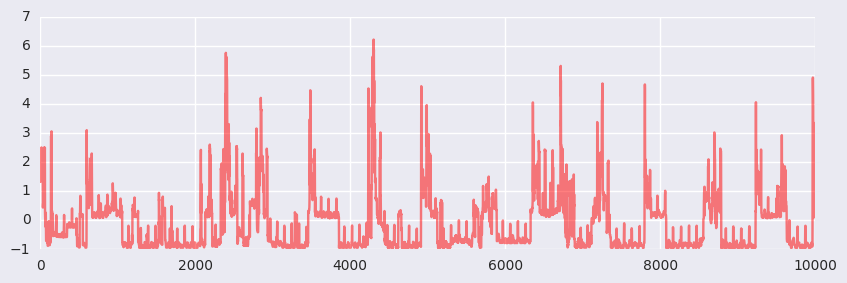

In [3]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(y_test, 'r', alpha=0.5)
plt.gcf().set_size_inches((10,3))
fig.set_facecolor('#EAEAF2')
plt.grid(True)
plt.show()

In [ ]:
model = Sequential()    




# your model here




start = time.time()
model.compile(loss="mse", optimizer="rmsprop")
print("Compilation Time : ", time.time() - start)

In [ ]:
# change epochs, batch_size...


epochs = 1
model.fit(X_train, y_train,
          batch_size=10, 
          nb_epoch=epochs, 
          validation_split=0.05)
predicted = model.predict(X_test)
predicted = np.reshape(predicted, (predicted.size,))

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(y_test[250:450], 'r')
plt.plot(predicted[250:450], 'g')
plt.gcf().set_size_inches((10,3))
fig.set_facecolor('#EAEAF2')
plt.grid(True)
plt.show()

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(y_test, 'r', alpha=0.5)
plt.plot(predicted, 'g', alpha=0.5)
plt.gcf().set_size_inches((10,3))
fig.set_facecolor('#EAEAF2')
plt.grid(True)
plt.show()